### CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

# Комментарии к решению

## Выбор архитектуры
Для решения данной задачи были перепробованы три нейросети. Первая -- ResNET глубины порядка 30, информация о которой была получена на основе статьи создателей (https://arxiv.org/abs/1512.03385). Она выдала качество порядка 80%. Далее, были некоторые собственноручные модификации этой сети. Последний вариант сети был выбран WRN (https://arxiv.org/abs/1605.07146). Изначально, обучалась WRN небольшой глубины и ширины (16-2), затем выбирались большие значения. Наилучшая реализация сети (WRN 28-10) обучалась очень долго и не давала хорошего качества: градиенты взрывались от большого количества данных. Была выбрана реализация сети (WRN 40-4 и WRN 40-8), которая обучалась сравнимым с 28-10 временем, но давала хороший прирост с самого начала.


## Короткая выдержка логов работы:

### WRN 16-2, без аугментации данных
#####  training loss (in-iteration):		0.071519 
#####   train accuracy:		97.56 % 
#####   validation accuracy:		79.73 % 
#####   - было принятно аугментировать данные, чтобы повысить качество.

### WRN 40-4, с аугментацией данных, без dropout и регуляризации
#####  training loss (in-iteration):		0.103469 
#####  train accuracy:		97.03 % 
#####  validation accuracy:		87.22 %
#####   - было принято решение добавить dropout и регуляризацию
  
### WRN 28-10
##### не обучилась должным образом (градиенты переполнялись (уходили в nan))

### WRN 40-8, с аугментацией данных, l2-регуляризацией и dropout=0.3
#####   training loss (in-iteration):		1.173628 
#####   train accuracy:		98.19 % 
#####   validation accuracy:	90.04 % 
  
#####   - скорее всего, могла бы обучиться еще, j по случайности была выключена на сервере.
  
## Аугментация
Для аугментации был использован прием, описанный в статье Wide Residual Network: кроп и сдвиг на каждой картинке

## Технические особенности
#### Грабли, на которые я наступил (можете воспринимать как отзыв о задании)
- Часто jupyter терял данные о обучении. Их я стал логировать в файл.

- К большому сожалению, kernel jupyter notebook несколько раз выходил из строя, иногда получалось востановить коэфициенты сети, иногда нет. Так, например, последнее обучение сети, давало очень хороший рост и приближалось к решению, однако на новое обучение сети с нуля потребовалось бы не меньше 12 часов.

- В следующий раз буду логировать не только результаты работы, но и коэффициенты сети, чтобы не делать одну и туже работу дважды

- Взял сервер p2.xlarge на AWS

- Очень много времени потратил на настройку окружения AWS, потом плюнул и стал использовать AMI Bitfusion (оказывается, он еще и пять дней бесплатного триала дает)

- Суммарно сервер работал 51 час

- Время ожидания от получения аккаунта на AWS до запуска кода на сервере заняло 5 дней. Из них один день -- проверка аккаунта, 3 дня -- ожидание ревью на сервер и еще один день -- настройка окружения.

- Много эксперементировал с learning_rate, вроде помогало, но не очень ясно именно его нужно было улучшать или думать над регуляризацией или структурой сетки


## Summary
- Детально, логи можно посмотреть в файле <i>'Malyshev_WRN_AUGMENT.log'</i> (jupyter notebook из-за переодических отключений и переподключений оставлял старые данные прогонов, так что лучше смотреть логи, чем результаты в jupyter notebook). Раздел с проверкой на тестовой выборке (где batchsize=500) запустил только для WRN 40-4. Результат получился <b>86.94 %</b>, кажется, он отличается от того качества, что было при обучении из-за того, что batchsize выбран много больше, чем при обучении.
- Также обучил сеть WRN 40-8 с качеством <b>90.04 %</b>, но по случайности она была выключена на сервере.



In [ ]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = 'cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

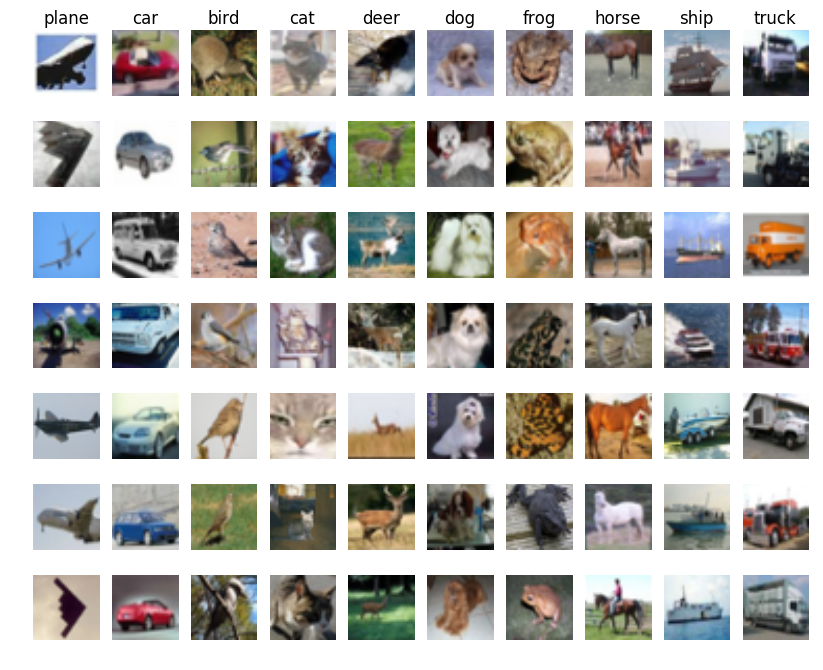

In [11]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Раньше сверточные сети были небольшой глубины (меньше 20 слоев). Сейчас научились делать глубокие нейронки (больше 150 слоев) с помощью линков и активаций на разных глубинах.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Могут начать затухать градиенты, первые слои не будут обучаться. Долго обучаются. Могут кончиться деньги на сервера. Исчезнет личная жизнь.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Нейросеточка будет как Эллочка-Людоедка: выучиться ну уж очень плохо. А сеточка хочет много данных. Можно использовать предобученные нейронные сети, сделать файн тюннинг либо использовать веса этой сетки для начальных весов новой сеточки. Второй вариант решения: насемплировать данных бутстрепом, поворотом картинок, наложением шумов и др. преобразованиями.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Преобразованием Фурье получим спектрограмму. Ее можно интерпретировать как изображением. Затем применим стайл трансфер аналогично изображениям.

In [12]:
import theano

In [13]:
import lasagne

In [14]:
from theano import tensor as T

In [15]:
from lasagne.nonlinearities import *

In [16]:
input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

Я использовал vgg - pretrained model по этому гайду: https://github.com/Lasagne/Recipes/blob/master/examples/ImageNet%20Pretrained%20Network%20%28VGG_S%29.ipynb
https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py


In [17]:
# downloading pre-trained vgg model
# !wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl

In [18]:
# from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import batch_norm
from lasagne.layers import DropoutLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import Pool2DLayer
from lasagne.layers import FlattenLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
# from lasagne.layers import PadLayer
# from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
# from lasagne.nonlinearities import softmax, rectify
# from lasagne.layers import batch_norm

In [74]:
def Build_small_block(net, dim, width=1, first_stride=1, dropout=0.0):
    left = Build_left33(net, dim, width, first_stride, dropout=dropout)
    
    right = ConvLayer(net, dim * width, filter_size=(1, 1),
                                stride=(first_stride, first_stride),
                                pad=(0, 0),
                                nonlinearity=None
                     )
    print("Build_small_block left: ", left.output_shape)
    print("Build_small_block right: ", right.output_shape)
    net_1 = ElemwiseSumLayer([left, right])
    print("Build_small_block: ", net_1.output_shape)
    return net_1

In [20]:
def batch_relu(net):
    left = batch_norm(net)
    left = NonlinearityLayer(left, nonlinearity=rectify)
    print("batch_relu: ", left.output_shape)
    return left

In [75]:
def Build_big_block(net, dim, width=1, first_stride=1, dropout=0.0):
    left = batch_relu(net)
    left = Build_left33(left, dim, width, first_stride, dropout)
    right = net
    print("Build_big_block left: ", left.output_shape)
    print("Build_big_block right: ", right.output_shape)
    net_1 = ElemwiseSumLayer([left, right])
    print("Build_big_block: ", net_1.output_shape)
    return net_1

In [ ]:
def Build_left33(net, dim, width=1, first_stride=1, dropout=0.0):
    left = ConvLayer(net, dim * width,
                    filter_size=(3,3),
                    stride=(first_stride,first_stride),
                    pad=(1, 1),
                    nonlinearity=None)
    left = batch_relu(left)
    if dropout != 0.0:
        left = DropoutLayer(left, p=dropout)
    left = ConvLayer(left,
                      dim * width,
                      filter_size=(3, 3),
                      stride=(1, 1),
                      pad=(1, 1),
                     nonlinearity=None)
    print("Build_left33: ", left.output_shape)
    return left

In [23]:
def init_network(input_X):
    net = InputLayer(shape=(None, 3, 32, 32),
                                    input_var=input_X)
    net = ConvLayer(net,
                    16,
                    filter_size=(3,3),
                    stride=(1, 1),
                    pad=(1, 1),
                    nonlinearity=rectify
                    )
    net = batch_norm(net)
    net = NonlinearityLayer(net, nonlinearity=rectify)
    print("init_network: ", net.output_shape)
    return net

In [24]:
def finilization(net):
    net1 = batch_norm(net)
    net1 = NonlinearityLayer(net, nonlinearity=rectify)
    net1 = Pool2DLayer(net,
                       pool_size=8,
                       stride=(1, 1),
                       ignore_border=True,
                       pad=(3, 3),
                       mode='average_exc_pad')  # average pooling
    print("after pooling: ", net1.output_shape)
    net1 = FlattenLayer(net1, outdim=2)
    print("after flatten: ", net1.output_shape)
    net1 = NonlinearityLayer(net, outdim=10, nonlinearity=softplus)
    return net1

In [76]:
def build_net(input_X, width=2):
    net = init_network(input_X)
    merge1 = Build_small_block(net, dim=16, width=width, dropout=0.3)
    merge2 = Build_big_block(merge1, dim=16, width=width, dropout=0.3)
    merge3 = Build_big_block(merge2, dim=16, width=width, dropout=0.3)
    merge3 = Build_big_block(merge3, dim=16, width=width, dropout=0.3)# extra
    print('1 section begins')
    activated1 = batch_relu(merge3)
    merge4 = Build_small_block(activated1, dim=32, width=width, first_stride=2)
    merge5 = Build_big_block(merge4, dim=32, width=width, dropout=0.3)
    merge6 = Build_big_block(merge5, dim=32, width=width, dropout=0.3)
    merge6 = Build_big_block(merge6, dim=32, width=width, dropout=0.3)
    print('2 section begins')
    activated2 = batch_relu(merge6)
    merge7 = Build_small_block(activated2, dim=64, width=width, first_stride=2, dropout=0.2)
    merge8 = Build_big_block(merge7, dim=64, width=width, dropout=0.3)
    merge9 = Build_big_block(merge8, dim=64, width=width, dropout=0.3)
    merge9 = Build_big_block(merge9, dim=64, width=width, dropout=0.3)
    activated3 = batch_relu(merge9)
    merge10 = Build_small_block(activated3, dim=128, width=width, first_stride=2, dropout=0.2)
    merge11 = Build_big_block(merge10, dim=128, width=width, dropout=0.3)
    merge12 = Build_big_block(merge11, dim=128, width=width, dropout=0.3)
    merge13 = Build_big_block(merge12, dim=128, width=width, dropout=0.3)
    print('finalization begins')
    net = finilization(merge13)
    return net

In [77]:
net = build_net(input_X, width=8)

('init_network: ', (None, 16, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('Build_left33: ', (None, 128, 32, 32))
('Build_small_block left: ', (None, 128, 32, 32))
('Build_small_block right: ', (None, 128, 32, 32))
('Build_small_block: ', (None, 128, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('Build_left33: ', (None, 128, 32, 32))
('Build_big_block left: ', (None, 128, 32, 32))
('Build_big_block right: ', (None, 128, 32, 32))
('Build_big_block: ', (None, 128, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('Build_left33: ', (None, 128, 32, 32))
('Build_big_block left: ', (None, 128, 32, 32))
('Build_big_block right: ', (None, 128, 32, 32))
('Build_big_block: ', (None, 128, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('batch_relu: ', (None, 128, 32, 32))
('Build_left33: ', (None, 128, 32, 32))
('Build_big_block left: ', (None, 128, 32, 32))
('Build_big_block right: ', (None, 128, 32, 32))
('Build_big_

In [78]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, beta, gamma, W, b, W, b]


In [80]:
%%time
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y)
loss = loss.mean() + 0.00005*lasagne.regularization.regularize_layer_params(lasagne.layers.get_all_layers(net),
                                                                              lasagne.regularization.l2
                                                                             )
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

CPU times: user 84.8 ms, sys: 0 ns, total: 84.8 ms
Wall time: 57.7 ms


In [81]:
lr = 0.005
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.momentum(loss,
                                   all_weights,
                                   learning_rate=sh_lr,
                                   momentum=0.9)

In [82]:
%%time
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)

CPU times: user 1min 54s, sys: 1.81 s, total: 1min 56s
Wall time: 1min 56s


In [83]:
train_fun(X_train[1:5,:,:,:], y_train[1:5])

[array(3.998089075088501, dtype=float32), array(0.25)]

### Вот и всё, пошли её учить

In [84]:
# def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
#     assert len(inputs) == len(targets)
#     if shuffle:
#         indices = np.arange(len(inputs))
#         np.random.shuffle(indices)
#     for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
#         if shuffle:
#             excerpt = indices[start_idx:start_idx + batchsize]
#         else:
#             excerpt = slice(start_idx, start_idx + batchsize)
#         yield inputs[excerpt], targets[excerpt]

In [85]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [ ]:
import time

num_epochs = 5 #количество проходов по данным

batch_size = 50 #размер мини-батча
i = 0
max_iter = 10000000
for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if i % 250 == 0:
            print('training: ', train_err, train_acc)
        i += (i + 1) % max_iter
            

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
        if epoch == 0:
            f.write("-------------NEW ERA -----------\n")
        f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
        new_lr = max(0.0005, sh_lr.get_value() * 0.1)
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Decressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    else:
        new_lr = max(0.0005, 0.01/np.sqrt(epoch + 1))
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Incressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


('training: ', 8.4327125549316406, 0.12)
Epoch 1 of 5 took 2612.655s
  training loss (in-iteration):		1.794610
  train accuracy:		37.33 %
  validation accuracy:		49.64 %


In [ ]:
import time

num_epochs = 5 #количество проходов по данным

batch_size = 50 #размер мини-батча
i = 0
max_iter = 10000000
for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if i % 250 == 0:
            print('training: ', train_err, train_acc)
        i += (i + 1) % max_iter
            

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
        f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
        new_lr = max(0.0005, sh_lr.get_value() * 0.1)
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Decressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    else:
        new_lr = max(0.0005, 0.01/np.sqrt(epoch + 1))
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Incressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

In [ ]:
import time

num_epochs = 5 #количество проходов по данным

batch_size = 50 #размер мини-батча
i = 0
max_iter = 10000000
for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if i % 250 == 0:
            print('training: ', train_err, train_acc)
        i += (i + 1) % max_iter
            

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
        f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
        new_lr = max(0.0005, sh_lr.get_value() * 0.1)
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Decressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    else:
        new_lr = max(0.0005, 0.01/np.sqrt(epoch + 1))
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Incressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

In [45]:
# import time

# num_epochs = 5 #количество проходов по данным

# batch_size = 50 #размер мини-батча
# i = 0
# max_iter = 10000000
# for epoch in xrange(5, num_epochs+5):
#     # In each epoch, we do a full pass over the training data:
#     train_err = 0
#     train_acc = 0
#     train_batches = 0
#     start_time = time.time()
#     for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
#         inputs, targets = batch
#         train_err_batch, train_acc_batch= train_fun(inputs, targets)
#         train_err += train_err_batch
#         train_acc += train_acc_batch
#         train_batches += 1
#         if i % 250 == 0:
#             print('training: ', train_err, train_acc)
#         i += (i + 1) % max_iter
            

#     # And a full pass over the validation data:
#     val_acc = 0
#     val_batches = 0
#     for batch in iterate_minibatches(X_test, y_test, batch_size):
#         inputs, targets = batch
#         val_acc += accuracy_fun(inputs, targets)
#         val_batches += 1

#     # Then we print the results for this epoch:
#     with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
#         if epoch == 0:
#             f.write("-------------NEW ERA -----------\n")
#         f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
#         f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
#         f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
#         f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
#     print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
#     print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
#     print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
#     if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
#         new_lr = max(0.000001, sh_lr.get_value() * 0.1)
#         with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
#             f.write("Decressing LR. New LR:" + str(new_lr))
#         sh_lr.set_value(lasagne.utils.floatX(new_lr))
#     else:
#         new_lr = max(0.000001, 0.01/np.sqrt(epoch + 1))
#         with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
#             f.write("Incressing LR. New LR:" + str(new_lr))
#         sh_lr.set_value(lasagne.utils.floatX(new_lr))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


('training: ', 0.58191394805908203, 0.81999999999999995)
Epoch 6 of 5 took 823.689s
  training loss (in-iteration):		0.479416
  train accuracy:		83.79 %
  validation accuracy:		80.60 %
Epoch 7 of 5 took 824.370s
  training loss (in-iteration):		0.396127
  train accuracy:		86.61 %
  validation accuracy:		81.33 %
Epoch 8 of 5 took 824.728s
  training loss (in-iteration):		0.341886
  train accuracy:		88.40 %
  validation accuracy:		82.52 %
Epoch 9 of 5 took 824.216s
  training loss (in-iteration):		0.296065
  train accuracy:		90.13 %
  validation accuracy:		82.28 %
Epoch 10 of 5 took 824.350s
  training loss (in-iteration):		0.254425
  train accuracy:		91.46 %
  validation accuracy:		83.61 %


In [46]:
# now_epoch = epoch

In [47]:
# import time

# num_epochs = 5 #количество проходов по данным

# batch_size = 50 #размер мини-батча
# i = 0
# max_iter = 10000000
# for epoch in xrange(now_epoch, num_epochs+now_epoch):
#     # In each epoch, we do a full pass over the training data:
#     train_err = 0
#     train_acc = 0
#     train_batches = 0
#     start_time = time.time()
#     for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
#         inputs, targets = batch
#         train_err_batch, train_acc_batch= train_fun(inputs, targets)
#         train_err += train_err_batch
#         train_acc += train_acc_batch
#         train_batches += 1
#         if i % 250 == 0:
#             print('training: ', train_err, train_acc)
#         i += (i + 1) % max_iter
            

#     # And a full pass over the validation data:
#     val_acc = 0
#     val_batches = 0
#     for batch in iterate_minibatches(X_test, y_test, batch_size):
#         inputs, targets = batch
#         val_acc += accuracy_fun(inputs, targets)
#         val_batches += 1

#     # Then we print the results for this epoch:
#     with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
#         if epoch == 0:
#             f.write("-------------NEW ERA -----------\n")
#         f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
#         f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
#         f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
#         f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
#     print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
#     print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
#     print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
#     if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
#         new_lr = max(0.000001, sh_lr.get_value() * 0.1)
#         with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
#             f.write("Decressing LR. New LR:" + str(new_lr))
#         sh_lr.set_value(lasagne.utils.floatX(new_lr))
#     else:
#         new_lr = max(0.000001, 0.01/np.sqrt(epoch + 1))
#         with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
#             f.write("Incressing LR. New LR:" + str(new_lr))
#         sh_lr.set_value(lasagne.utils.floatX(new_lr))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


('training: ', 0.16127100586891174, 0.95999999999999996)
Epoch 10 of 5 took 825.075s
  training loss (in-iteration):		0.224682
  train accuracy:		92.53 %
  validation accuracy:		83.08 %
Epoch 11 of 5 took 825.682s
  training loss (in-iteration):		0.201229
  train accuracy:		93.13 %
  validation accuracy:		83.36 %
Epoch 12 of 5 took 825.085s
  training loss (in-iteration):		0.175996
  train accuracy:		93.94 %
  validation accuracy:		83.10 %
Epoch 13 of 5 took 824.754s
  training loss (in-iteration):		0.114264
  train accuracy:		96.29 %
  validation accuracy:		86.25 %
Epoch 14 of 5 took 825.691s
  training loss (in-iteration):		0.086029
  train accuracy:		97.37 %
  validation accuracy:		86.38 %


In [48]:
# now_epoch = epoch

In [49]:
test_acc = 0
testdeepcopyys = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		86.95 %
Нужно больше магии!


## Добивочка

In [50]:
import time

num_epochs = 20 #

batch_size = 50 #размер мини-батча
i = 0
max_iter = 10000000
for epoch in xrange(now_epoch, num_epochs+now_epoch):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if i % 250 == 0:
            print('training: ', train_err, train_acc)
        i += (i + 1) % max_iter
            

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
        if epoch == 0:
            f.write("-------------EXTRA_LEARNING -----------\n")
        f.write("Epoch {} of {} took {:.3f}s \n".format(epoch + 1, num_epochs, time.time() - start_time))
        f.write("  training loss (in-iteration):\t\t{:.6f} \n".format(train_err / train_batches))
        f.write("  train accuracy:\t\t{:.2f} % \n".format(train_acc / train_batches * 100))
        f.write("  validation accuracy:\t\t{:.2f} % \n".format(val_acc / val_batches * 100))
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    if ((train_acc / train_batches * 100) - (val_acc / val_batches * 100) > 10):
        new_lr = max(0.0000001, sh_lr.get_value() * 0.1)
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Decressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    else:
        new_lr = max(0.0000001, 0.01/np.sqrt(epoch + 1))
        with open("Malyshev_WRN_AUGMENT.log", "a+") as f:
            f.write("Incressing LR. New LR:" + str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


('training: ', 0.11274205893278122, 0.93999999999999995)
Epoch 14 of 20 took 824.179s
  training loss (in-iteration):		0.082268
  train accuracy:		97.45 %
  validation accuracy:		86.35 %
Epoch 15 of 20 took 824.785s
  training loss (in-iteration):		0.082426
  train accuracy:		97.52 %
  validation accuracy:		86.35 %
Epoch 16 of 20 took 824.385s
  training loss (in-iteration):		0.080212
  train accuracy:		97.55 %
  validation accuracy:		86.35 %
Epoch 17 of 20 took 824.910s
  training loss (in-iteration):		0.082253
  train accuracy:		97.53 %
  validation accuracy:		86.35 %
Epoch 18 of 20 took 823.549s
  training loss (in-iteration):		0.081772
  train accuracy:		97.52 %
  validation accuracy:		86.35 %
Epoch 19 of 20 took 824.608s
  training loss (in-iteration):		0.081031
  train accuracy:		97.56 %
  validation accuracy:		86.35 %
Epoch 20 of 20 took 824.406s
  training loss (in-iteration):		0.083671
  train accuracy:		97.43 %
  validation accuracy:		86.35 %
Epoch 21 of 20 took 824.822s
  tr

In [51]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		86.94 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 